<a href="https://colab.research.google.com/github/nargesalavi/Quantum-Open-Source-Foundation-Mentorship/blob/master/QNN_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task 1: Quantum Neural Network for State Approximation


In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

In [4]:
qubits = cirq.GridQubit.rect(1, 4)

In [5]:
def generate_even_block(block_number):
    """ Function for generating the even blocks
        Arguments:
          block_number: Block number, it has to be even.
        return: ciq.Circuit """
    params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

    # create the parameterized circuit
    circuit = cirq.Circuit(
        cirq.rz(params[0])(qubits[0]),
        cirq.rz(params[1])(qubits[1]),
        cirq.rz(params[2])(qubits[2]),
        cirq.rz(params[3])(qubits[3]),
        cirq.CZ(qubits[0],qubits[1]),
        cirq.CZ(qubits[0],qubits[2]),
        cirq.CZ(qubits[0],qubits[3]),
        cirq.CZ(qubits[1],qubits[2]),
        cirq.CZ(qubits[1],qubits[3]),
        cirq.CZ(qubits[2],qubits[3])
    )
    
    return circuit

In [6]:
def generate_odd_block(block_number):
    """ Function for generating the odd blocks
        block_number: Block number, it has to be odd.
        return: ciq.Circuit """
    params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

    # create the parameterized circuit
    circuit = cirq.Circuit(
        cirq.rx(params[0])(qubits[0]),
        cirq.rx(params[1])(qubits[1]),
        cirq.rx(params[2])(qubits[2]),
        cirq.rx(params[3])(qubits[3])
    )
    
    return circuit

In [7]:
def generate_qnn(l):
    """ Function for generating qnn, containing l number of layers.
        Arguments:
          l: number of layers, each layer contains one odd and one even block.
        return: ciq.Circuit """
    circuit = cirq.Circuit()
    for i in range(1,2*l+1):
        if i % 2 == 1:
            circuit += generate_odd_block(i)
        else:
            circuit += generate_even_block(i)
        
    return circuit

In [8]:
l=1
qnn = generate_qnn(l)
print(qnn)

                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘


In [9]:
params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
print(params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])

tf.Tensor(
[[0.8488936  0.01440429 4.5239477  4.2941794  2.438894   0.19482155
  5.517225   1.287356  ]], shape=(1, 8), dtype=float32)


In [10]:
state_layer = tfq.layers.State()
state = state_layer(qnn, symbol_names=params_names, symbol_values=params)
print(qnn)
print(state)

Instructions for updating:
reduction_indices is deprecated, use axis instead
                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘
<tf.RaggedTensor [[(0.002139464020729065+0.3165188431739807j), (-0.1393662542104721-0.46668529510498047j), (-0.27394235134124756+0.2670826017856598j), (-0.2897740602493286+0.5124556422233582j), (0.00223951181396842+0.0004261998110450804j), (0.0034919241443276405-0.0003340726834721863j), (-0.001505257561802864-0.002308071358129382j), (0.0032169946935027838+0.0027620585169643164j), (-0.10852922499179

In [11]:
random_circuit = cirq.testing.random_circuit(qubits = qubits,n_moments = np.random.randint(low=1,high=5),\
                                                                op_density = 0.99999999)
print(random_circuit)
target_state = tfq.layers.State()(random_circuit)
print(target_state)

                   ┌──┐
(0, 0): ───X───×────Z─────iSwap───
               │          │
(0, 1): ───@───┼─────@────iSwap───
           │   │     │
(0, 2): ───@───×────Y┼────X───────
                     │
(0, 3): ───────H─────X────────────
                   └──┘
<tf.RaggedTensor [[(3.3035794779146194e-15-3.0908619663705394e-08j), (5.2142649430793244e-15-3.0908619663705394e-08j), (1.1083170647907536e-07-0.7071067690849304j), (1.5454310187124065e-07-0.7071067690849304j), (6.195666538404837e-15-3.0908619663705394e-08j), (8.106351791811305e-15-3.0908619663705394e-08j), (-1.351058949605906e-15+1.3510583143311957e-15j), (-1.3510590554850245e-15+1.3510582084520772e-15j), (1.3510586319685509e-15+2.7082117417700954e-22j), (1.3510586319685509e-15+3.5433988507490094e-22j), (-5.905663278707993e-23-5.905666434151613e-23j), (-5.905663278707993e-23-5.905666434151613e-23j), 0j, 0j, 0j, 0j]]>


In [12]:
def states_distance(state,target):
  diff = state[0] - target[0]
  diff = tf.reshape(diff, [16, 1])
  conjugate_transposed_state = tf.transpose(diff,conjugate=True)
  distance = tf.tensordot(conjugate_transposed_state, diff, axes = 1)
  #print('distance:' , distance, 'state:', state)
  return tf.dtypes.cast(distance, tf.float32)

In [13]:
# gradient(theta[i]) = function(theta)
def custom_gradient(params, target_state, parameter_shift = True, h = np.pi/2):
  """ This function calculates the gradients of the quantum circuit's parameters 
      using two methods: Parameter shift rules or Numerical differentiation.
      In numerical differentiation method, for Pauli gates the shift value is pi/2 and the ratio is 1/2. 
      Arguments:
        params: circuit's parameters, of which the gradient is calculated.
        target_state: The target state, which the quantum NN trys to approximate.
        parameter_shift: Determine which method is used to calculate the gradients. 
                         When it is True, the function uses parameter shift otherwise it uses numerical differentiation.
        h: The shift value for parameter. When parameter shift method is used, it is pi/2."""
  param_length = len(params[0])
  grad = [None]*param_length
  if parameter_shift : 
    r = 1/2
    h = np.pi/2
  else:
    r = 1/(2*h)
  for i in range(param_length):
    
    params_plus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]+h],params[0][i+1:]))])
    params_minus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]-h],params[0][i+1:]))])
    state_plus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_plus_h)
    state_minus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_minus_h)
    #print('i', i, 'state_plus_h:', state_plus_h, 'state_minus_h:', state_minus_h) 
    grad[i] = r*(states_distance(state_plus_h,target_state)-states_distance(state_minus_h,target_state))

  return grad

In [14]:
def update_params(params, gradients, learning_rate):
  gradients = tf.reshape(gradients,[1,len(params[0])])
  params -= learning_rate*gradients
  #params = params % (2*np.pi)
  return params


In [15]:
L = 10
learning_rate = 0.01
number_of_iteration = 1000

In [16]:
#for i in range (1,10):
list_of_e =[]
for l in range(1,L+1):
  print('***** l:', l)
  qnn = generate_qnn(l)
  params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
  params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])
  eValues = []
  for i in range(number_of_iteration):
    params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
    params = update_params(params, params_grads,learning_rate)

    approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
    e = states_distance(approximation,target_state)
    eValues.append(e[0][0])

    if i % 80 == 0:
      print('i:', i, 'e:', e)
  path = '/content/mydrive/layer_{}'.format(l)
  np.savetxt(path, eValues, delimiter=',')
  list_of_e.append(eValues)
print(e)

***** l: 1
i: 0 e: tf.Tensor([[1.8940599]], shape=(1, 1), dtype=float32)
i: 80 e: tf.Tensor([[1.8389353]], shape=(1, 1), dtype=float32)
i: 160 e: tf.Tensor([[1.7497419]], shape=(1, 1), dtype=float32)
i: 240 e: tf.Tensor([[1.6071982]], shape=(1, 1), dtype=float32)
i: 320 e: tf.Tensor([[1.3919888]], shape=(1, 1), dtype=float32)
i: 400 e: tf.Tensor([[1.1029985]], shape=(1, 1), dtype=float32)
i: 480 e: tf.Tensor([[0.7775721]], shape=(1, 1), dtype=float32)
i: 560 e: tf.Tensor([[0.4810985]], shape=(1, 1), dtype=float32)
i: 640 e: tf.Tensor([[0.26375493]], shape=(1, 1), dtype=float32)
i: 720 e: tf.Tensor([[0.13207199]], shape=(1, 1), dtype=float32)
i: 800 e: tf.Tensor([[0.06256713]], shape=(1, 1), dtype=float32)
i: 880 e: tf.Tensor([[0.02878763]], shape=(1, 1), dtype=float32)
i: 960 e: tf.Tensor([[0.0130609]], shape=(1, 1), dtype=float32)
***** l: 2
i: 0 e: tf.Tensor([[2.4219816]], shape=(1, 1), dtype=float32)
i: 80 e: tf.Tensor([[1.8059202]], shape=(1, 1), dtype=float32)
i: 160 e: tf.Tensor(

In [ ]:
eValues = tf.reshape(eValues,[1,1000])

In [28]:
print(len(params[0]))

16


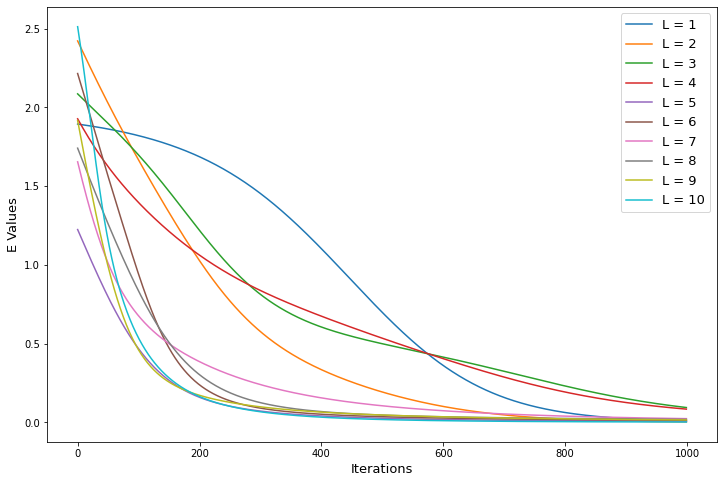

In [17]:
plt.figure(figsize=(12, 8))
for l in range(L):
  label='L = {}'.format(l+1)
  #plt.plot(aliceboblosses[:steps], label='Alice_Bob')
  plt.plot(list_of_e[l],label = label)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("E Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [ ]:
  approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
  e = states_distance(approximation,target_state)
  print('params:', params, params% 2*np.pi, 'e:', e)

params: tf.Tensor(
[[5.8125076 3.082775  5.554178  3.536392  8.038719  1.7454691 3.7011755
  0.5023185]], shape=(1, 8), dtype=float32) tf.Tensor(
[[5.694161   3.4016385  4.882595   4.826718   0.12163989 5.483553
  5.3444004  1.5780802 ]], shape=(1, 8), dtype=float32) e: tf.Tensor([[0.6126985]], shape=(1, 1), dtype=float32)
